In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from summit import *
from multitask import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from botorch.models import MultiTaskGP, SingleTaskGP, MixedSingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import (
    ExactMarginalLogLikelihood,
)

import torch

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Functions

In [3]:
# Transform inputs
def get_ct(continuous_features, ordinal_features):
    transformers = []
    transformers.append(
        (
            "continuous",
            StandardScaler(),
            continuous_features
        )
    )
    if type(ordinal_features) == list:
        transformers.append(
            (
                "ordinal",
                OrdinalEncoder(),
                ordinal_features
            )
        )
    elif type(ordinal_features) == dict:
        categories = [cats for cats in ordinal_features.values()]
        transformers.append(
            (
                "ordinal",
                OrdinalEncoder(categories=categories),
                list(ordinal_features.keys())
            )
        )
    return ColumnTransformer(transformers)

In [4]:
def parity_plot(result: dict, ax: plt.Axes = None):
    # Train resultss
    model = result["model"]
    train_posterior = model.posterior(torch.tensor(result["train_X"]))
    train_y_pred_mean = train_posterior.mean.detach()
    train_y_pred_std = train_posterior.variance.sqrt()
    train_y_pred_mean = result["output_transform"].inverse_transform(train_y_pred_mean)
    print(train_y_pred_mean.shape)
    train_y = result["output_transform"].inverse_transform(result["train_y"])
    print(train_y.shape)

    # Plotting
    if ax is None:
        fig, ax = plt.subplots(1)
    ax.plot([0,100], [0,100], "--")
    ax.scatter(train_y, train_y_pred_mean, label="Train")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    if result.get("test_X") is not None and result.get("test_y") is not None:
        test_posterior = model.posterior(torch.tensor(result["test_X"]))
        test_y_pred_mean = test_posterior.mean.detach()
        test_y_pred_std = test_posterior.variance.sqrt()
        test_y_pred_mean = result["output_transform"].inverse_transform(test_y_pred_mean)
        test_y = result["output_transform"].inverse_transform(result["test_y"])
        ax.scatter(test_y, test_y_pred_mean, label="Test")
        mae = mean_absolute_error(test_y, test_y_pred_mean)
        print(f"Test MAE: {mae}")
        
    #Format
    ax.legend()

## Generate Data

In [5]:
exp_pt = MIT_case1(noise_level=1)
exp_pt.domain

Name,Type,Description,Values
conc_cat,"continuous, input",catalyst concentration,"[0.000835,0.004175]"
t,"continuous, input",reaction time,"[60,600]"
cat_index,"categorical, input",Choice of catalyst,8 levels
temperature,"continuous, input",Reactor temperature in degress celsius,"[30,110]"
y,"continuous, maximize objective",yield (%),"[0,100]"


We first generate different amounts of data using latin hypercube sampling.

Now, we can run single-task and multi-task Bayesian optimization.

In [6]:
def generate_mit_case_1_data(n_points):
    exp_pt = MIT_case1(noise_level=1)
    rs = np.random.RandomState(100)
    lhs = LHS(exp_pt.domain, random_state=rs)
    conditions = lhs.suggest_experiments(n_points)
    exp_pt.run_experiments(conditions)
    pt_data = exp_pt.data
    pt_data['task', 'METADATA'] = 0
    return pt_data

n_aux = [5, 10, 50]
aux_datasets = [generate_mit_case_1_data(n) for n in n_aux]

In [21]:
def generate_mit_case_2_data(n_points):
    exp_pt = MIT_case2(noise_level=1)
    rs = np.random.RandomState(100)
    lhs = LHS(exp_pt.domain, random_state=rs)
    conditions = lhs.suggest_experiments(n_points)
    exp_pt.run_experiments(conditions)
    pt_data = exp_pt.data
    pt_data['task', 'METADATA'] = 1
    return pt_data

data = generate_mit_case_2_data(20)

In [26]:
df = pd.DataFrame(data.data_to_numpy(), columns=data.data_columns)
continuous_features = [
    "conc_cat", "temperature", "t"
]
ordinal_features = ["cat_index"]
features = continuous_features + ordinal_features
features.append("y")

df = df.copy()[features]

input_transform = get_ct(
    continuous_features=continuous_features,
    ordinal_features=ordinal_features
)

train_df, test_df = train_test_split(df, test_size=0.75)
train_X = input_transform.fit_transform(train_df)
test_X = input_transform.fit_transform(test_df)
output_scaler = StandardScaler()
train_y = output_scaler.fit_transform(train_df[["y"]])
test_y = output_scaler.fit_transform(test_df[["y"]])

## Train Single Task Model

In [29]:
model = MixedSingleTaskGP(
    train_X=torch.tensor(train_X),
    train_Y=torch.tensor(train_y),
    cat_dims=[-1]
)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
_ = fit_gpytorch_model(mll)

In [30]:
result =  {
    "input_transform": input_transform,
    "output_transform": output_scaler,
    "train_X": train_X,
    "train_y": train_y,
    "test_X": test_X,
    "test_y": test_y,
    "model": model
}

(5, 1)
(5, 1)
Test MAE: 0.3015026012628244


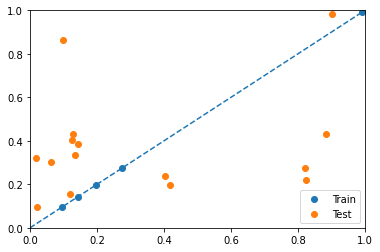

In [31]:
fig, ax = plt.subplots(1)
parity_plot(result, ax)

## Compare ICM and LCM models

### ICM 

In [32]:
# Tasks
train_df_new = train_df.copy()
train_df_new["task"] = 1
aux_number = 1
df_aux = pd.DataFrame(
    aux_datasets[aux_number].data_to_numpy(),
    columns=aux_datasets[aux_number].data_columns
)
df_aux["task"] = 0
big_df = pd.concat([train_df_new, df_aux])

# Features
continuous_features = [
    "conc_cat", "temperature", "t"
]
ordinal_features = ["cat_index"]
features = continuous_features + ordinal_features
features.append("y")

# Transform
input_transform = get_ct(
    continuous_features=continuous_features,
    ordinal_features=ordinal_features
)


# Input transofrm
train_X_multitask = input_transform.fit_transform(big_df)
train_X_multitask = np.append(train_X_multitask, big_df[["task"]], axis=1).astype(
    np.float
)
train_X_task_1 = input_transform.fit_transform(train_df)
test_X_multitask = input_transform.fit_transform(test_df)

#Output transform
output_scaler = StandardScaler()
train_y_multitask = output_scaler.fit_transform(big_df[["y"]])
train_y_task_1 = output_scaler.fit_transform(train_df[["y"]])
test_y_multitask = output_scaler.fit_transform(test_df[["y"]])

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [33]:
model = MixedMultiTaskGP(
    train_X=torch.tensor(train_X_multitask),
    train_Y=torch.tensor(train_y_multitask),
    task_feature = -1,
    cat_dims=[-2],
    output_tasks=[1]
    
)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
_ = fit_gpytorch_model(mll)

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/botorch/fit.py:130: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(w.message, w.category)


In [34]:
result =  {
    "input_transform": input_transform,
    "output_transform": output_scaler,
    "train_X": train_X_task_1,
    "train_y": train_y_task_1,
    "test_X": test_X_multitask,
    "test_y": test_y_multitask,
    "model": model
}

(5, 1)
(5, 1)
Test MAE: 0.11764800311716125


/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


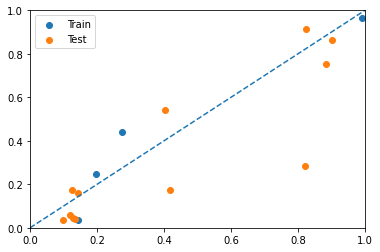

In [35]:
fig, ax = plt.subplots(1)
parity_plot(result, ax)

### LCM

In [36]:
model = LCMMultitaskGP(
    train_X=torch.tensor(train_X_multitask),
    train_Y=torch.tensor(train_y_multitask),
    num_independent_kernels=2,
    task_feature = -1,
    cat_dims=[-2],
    output_tasks=[1]
    
)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
_ = fit_gpytorch_model(mll)

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/botorch/fit.py:130: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(w.message, w.category)


In [37]:
result =  {
    "input_transform": input_transform,
    "output_transform": output_scaler,
    "train_X": train_X_task_1,
    "train_y": train_y_task_1,
    "test_X": test_X_multitask,
    "test_y": test_y_multitask,
    "model": model
}

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


(5, 1)
(5, 1)
Test MAE: 0.24390371084869536


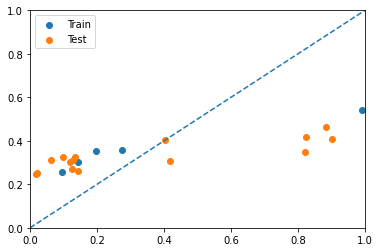

In [38]:
fig, ax = plt.subplots(1)
parity_plot(result, ax)